In [1]:
import os
import json
from typing import List, Dict
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score

## I. Data Handling

In [2]:
albumIndexes = {}

def getAlbumIndex(albumID: str):
    if (albumID not in albumIndexes):
        albumIndexes[albumID] = len(albumIndexes)
    return albumIndexes[albumID]

class CustomDataset(Dataset):
    def __init__(self, rootDirs: list[str], transform=None):
        """
        Custom dataset to provide both album and artist labels.

        Args:
            rootDir (str): Root directory containing the data.
            transform: Image transformations to apply.
        """
        self.rootDirs = rootDirs
        self.transform = transform
        self.data = []  # List of tuples (image_path, album_label)
        self.albumLabels = {}  # Mapping from album ID to index
        self.reverseAlbumLabels = {}  # Reverse mapping from index to album ID
        self._prepareDataset()

    def _prepareDataset(self):
        """
        Prepares the dataset by mapping images to album and artist labels.
        """

        for rootDir in self.rootDirs:

            for artistName in os.listdir(rootDir):
                artistPath = os.path.join(rootDir, artistName)
                if os.path.isdir(artistPath):

                    for albumName in os.listdir(artistPath):
                        albumPath = os.path.join(artistPath, albumName)
                        if (os.path.isdir(albumPath)):
                            # Assign a unique label to each album
                            albumID = f"{artistName}/{albumName}"
                            if (albumID not in self.albumLabels):
                                albumIndex = getAlbumIndex(albumID)
                                self.albumLabels[albumID] = albumIndex
                                self.reverseAlbumLabels[albumIndex] = albumID

                            for imgName in os.listdir(albumPath):
                                imgPath = os.path.join(albumPath, imgName)
                                if (imgPath.endswith(('.png', '.jpg', '.jpeg'))):
                                    self.data.append((
                                        imgPath,
                                        self.albumLabels[albumID]
                                    ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgPath, albumLabel = self.data[idx]
        image = Image.open(imgPath).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        return image, albumLabel


In [3]:
globalTransforms = [
    # ensure images are of uniform size
    # this is necessary for the neural network to be able to process the images
    transforms.Resize((224, 224)),

    # ensure the end result is a tensor
    # this converts the image from [0,255] to [0,1]
    # making it compatible with the neural network
    transforms.ToTensor(),

    # normalise the data
    transforms.Normalize(
        # this is the mean and standard deviation of the ImageNet dataset
        # the pixel value, for each channel, is subtracted by the mean and divided by the standard deviation
        # this should shift the pixel values to be centred around zero (mean: 0, std: 1)
        # this allows faster and more stable convergence during optimisation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]

globalTransformer = transforms.Compose(globalTransforms)

# LOAD DATASET
rootDir = globals()['_dh'][0] # os.path.dirname(os.path.abspath(__file__))
dataDir = os.path.join(rootDir, '..', 'data')

trainDirs = [
    os.path.join(dataDir, 'art_'),
    os.path.join(dataDir, 'art_a_dig'),
    os.path.join(dataDir, 'art_b_phys'),
    os.path.join(dataDir, 'art_c_dig'),
]

dataset = CustomDataset(rootDirs=trainDirs, transform=globalTransformer)

with open(os.path.join(dataDir, 'manifest.json'), 'r', encoding='utf-8') as f:
    trueClasses = json.load(f)

for i in range(5):
    print({
        dataset.data[i][0]: dataset.reverseAlbumLabels[dataset.data[i][1]],
    })
print(len(dataset))
print(len(trueClasses))

{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_\\_null\\_null\\null.jpg': '_null/_null'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcadeFire\\Funeral_ArcadeFire_2004\\front.png': 'ArcadeFire/Funeral_ArcadeFire_2004'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcadeFire\\TheSuburbs_ArcadeFire_2010\\front.png': 'ArcadeFire/TheSuburbs_ArcadeFire_2010'}
{"d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcticMonkeys\\WhateverPeopleSayIAm,That'sWhatI'mNot_ArcticMonkeys_2006\\front.png": "ArcticMonkeys/WhateverPeopleSayIAm,That'sWhatI'mNot_ArcticMonkeys_2006"}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\Björk\\Homogenic_Björk_1997\\back.png': 'Björk/Homogenic_Björk_1997'}
195
131


Note: Data augmentation should be done in the future, to create a more robust dataset.

In [4]:
# VERIFY DATASET INTREGRITY
error = False
for i in range(len(dataset)):
    try:
        img, label = dataset[i]
    except OSError as e:
        error = True
        print(trueClasses[dataset.albumLabels[label + 1]])

if (error):
    raise Exception('Dataset is corrupted')

In [5]:
artDir_test = os.path.join(dataDir, 'art_c_phys')
testDataset = CustomDataset(rootDirs=[artDir_test], transform=globalTransformer)
print(len(testDataset))

16


In [6]:
# SPLIT DATA
trainLoader = DataLoader(dataset, batch_size=8, shuffle=True)
validationLoader = DataLoader(testDataset, batch_size=8, shuffle=True)

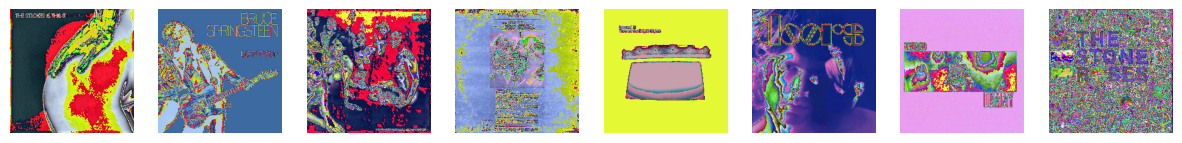

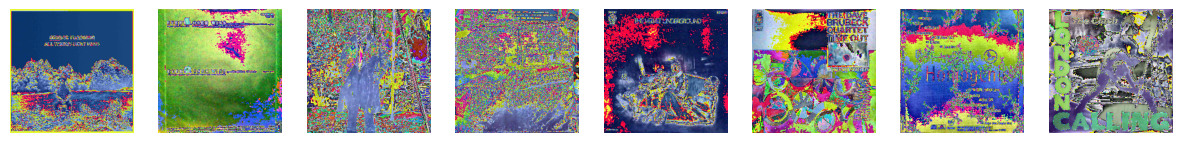

In [7]:
def showBatch(images):
    # Plot the images in the batch
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ii, image in enumerate(images):
        # Apply denormalization if necessary
        image = transforms.ToPILImage()(image)  # Convert to PIL image for display
        axes[ii].imshow(image)
        axes[ii].axis('off')
    plt.show()

for i, (images, _) in enumerate(trainLoader):
    showBatch(images)
    if (i >= 1):
        break

## II. Model

In [8]:
class SimpleCNN(nn.Module):
    """
    This is a simple convolutional neural network, for POC.
    It has two convolutional layers and two fully connected layers (see below).
    It effectively learns the 'ID' of the image (albumName_artistName).
    """

    def __init__(self, numClasses):
        super(SimpleCNN, self).__init__()

        # This is the architecture of the neural network.
        # It is composed of two convolutional layers and two fully connected layers.
        # conv1 -> pool -> conv2 -> pool -> fc1 -> fc2

        # CONVOLUTIONAL LAYER 1
        self.conv1 = nn.Conv2d(
            3, # 3 channels (RBG)
            32, # 32 output filters (feature maps)
            kernel_size=3, # each filter will scan 3x3 patches of the image
            stride=1, # each filter will move 1 pixel at a time
            padding=1 # the input is padded, to esnure the output is the same size as the input
        )

        # MAX-POOLING LAYER
        # reduces spatial dimensions of the input feature maps
        # this reduces the number of parameters and computations in the network
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # CONVOLUTIONAL LAYER 2
        # the 32 feature maps are now fed into a second layer, resulting in 64 output filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # FULLY CONNECTED LAYER 1
        self.fc1 = nn.Linear(
            64 * 56 * 56, # 64 feature maps, each 56x56 pixels
            128 # 128 output neurons
        )

        # FULLY CONNECTED LAYER 2
        # this layer outputs logits (raw scores) for each class
        self.fc2 = nn.Linear(128, numClasses)

    def forward(self, x):
        """_summary_

        Args:
            x (_type_): _description_

        Returns:
            _type_: _description_
        """

        # pool the first convolutional layer
        # the size of the feature maps are halved
        x = self.pool(
            # apply the ReLU activation function
            # this introduces non-linearity to the model
            torch.relu(
                # apply the first convolutional layer
                # the 32 filters are applied to the input image
                self.conv1(x)
            )
        )

        # pool the second convolutional layer
        x = self.pool(torch.relu(self.conv2(x)))

        # flatten the feature maps
        x = x.view(-1, 64 * 56 * 56)

        # fully-connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) # no activation function, as this is handled by the loss function

        return x

model = SimpleCNN(numClasses=len(dataset))

## III. Training

In [9]:
# LOSS FUNCTION
# used to compute the error between the model's predictions and the true labels
criterion = nn.CrossEntropyLoss()

# OPTIMISER
# updates the model's weights, based on gradients
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [11]:

def train(
    model, trainLoader, validationLoader, maxEpochs=5, learningRate=0.001, weightDecay=1e-4,
    patience=4, overallBestValLoss=0,
):
    """
    Train the model and evaluate on validation data each epoch.
    """
    print('\n', f'Training... (α={learningRate}, λ={weightDecay}, B={trainLoader.batch_size})')

    # LOSS FUNCTION
    # used to compute the error between the model's predictions and the true labels
    criterion = nn.CrossEntropyLoss()

    # OPTIMISER
    # updates the model's weights, based on gradients
    optimiser = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learningRate, weight_decay=weightDecay,
    )

    bestValLoss = float('inf')
    epochsSinceBest = 0

    for epoch in range(maxEpochs):

        # Training phase
        model.train()
        runningLoss = 0.0
        correct, total = 0, 0

        for images, labels in trainLoader:
            optimiser.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # prevent exploding gradients
            optimiser.step()

            runningLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        trainLoss = runningLoss / len(trainLoader)
        trainAccuracy = correct / total

        # Validation phase
        model.eval()
        valLoss = 0.0
        valCorrect, valTotal = 0, 0

        with torch.no_grad():
            for images, labels in validationLoader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                valLoss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valTotal += labels.size(0)
                valCorrect += (predicted == labels).sum().item()

        valLoss /= len(validationLoader)
        valAccuracy = valCorrect / valTotal

        print(
            f"(Epoch {epoch+1}) "
            f"Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.4f} || "
            f"Val Loss: {valLoss:.4f}, Val Accuracy: {valAccuracy:.4f}"
        )

        # early stopping
        if (valLoss < bestValLoss):
            bestValLoss = valLoss
            epochsSinceBest = 0

            if (valLoss < overallBestValLoss):
                overallBestValLoss = valLoss
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict(),
                    'val_loss': valLoss,
                }, f'simplecnn_large({overallBestValLoss}).pt')
        else:
            epochsSinceBest += 1

        if (epochsSinceBest >= patience):
            print('Early stopping triggered!')
            break

    return overallBestValLoss

model = SimpleCNN(numClasses=len(dataset))
train(
    model, trainLoader, validationLoader,
    maxEpochs=30, learningRate=1e-3, weightDecay=1e-4,
    patience=5,
)



 Training... (α=0.001, λ=0.0001, B=8)
(Epoch 1) Train Loss: 8.3558, Train Accuracy: 0.0000 || Val Loss: 5.2205, Val Accuracy: 0.0000
(Epoch 2) Train Loss: 4.9084, Train Accuracy: 0.0308 || Val Loss: 5.0940, Val Accuracy: 0.1250
(Epoch 3) Train Loss: 3.8877, Train Accuracy: 0.2154 || Val Loss: 5.1021, Val Accuracy: 0.0625
(Epoch 4) Train Loss: 2.3170, Train Accuracy: 0.4974 || Val Loss: 4.9589, Val Accuracy: 0.1875
(Epoch 5) Train Loss: 0.7348, Train Accuracy: 0.8872 || Val Loss: 6.9368, Val Accuracy: 0.0625
(Epoch 6) Train Loss: 0.2804, Train Accuracy: 0.9385 || Val Loss: 5.4296, Val Accuracy: 0.1875
(Epoch 7) Train Loss: 0.1393, Train Accuracy: 0.9744 || Val Loss: 6.8104, Val Accuracy: 0.1875
(Epoch 8) Train Loss: 0.0541, Train Accuracy: 0.9846 || Val Loss: 6.1213, Val Accuracy: 0.0625
(Epoch 9) Train Loss: 0.0283, Train Accuracy: 0.9897 || Val Loss: 4.8376, Val Accuracy: 0.2500
(Epoch 10) Train Loss: 0.0853, Train Accuracy: 0.9949 || Val Loss: 5.3860, Val Accuracy: 0.2500
(Epoch 11)

0

<div style="background-color: #f9f9b7; border-left: 6px solid #f1c40f; padding: 10px; color: #000000">
    <strong>Note:</strong> When training with a tiny dataset (~10 classes), high accuracy was reached incredibly quickly (~5 epochs). However, it was noted that raising this to ~100 classes required ~8 or more epochs in order to reach thesame level of convergence.

    The results of the smaller dataset can be seen in previous versions (git) of this notebook.
</div>


<div style="background-color: #f9f9b7; border-left: 6px solid #f1c40f; padding: 10px; color: #000000">
    <strong>Note:</strong> Increasing the dataset size to ~100 classes resulted in the model taking ~1m40s to train to high accuracy (10-12 epochs). GPU optimisation is recommended, if using a larger dataset.
</div>


## IV. Validation

In [12]:
def validate(model, testImage, printResult = True):
    model.eval()

    with torch.no_grad():
        outputs = model(testImage)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predictedProb, predictedClass = torch.max(probabilities, 1)

        predictedID = dataset.reverseAlbumLabels[predictedClass.item()].split('/')[1]
        predictedProb = predictedProb.item()

        if (printResult):
            print(f'Predicted: {predictedID} ({predictedProb})')
            print(trueClasses.get(predictedID, 'Unknown'))

    return (predictedID, predictedProb)

def validateImage(model, imagePath: str, imageWidth = 350, printResult = True):
    testImage = Image.open(imagePath)
    if (imageWidth > 0):
        displayImage(testImage, imageWidth)

    testImage = globalTransformer(testImage)
    testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

    return validate(model, testImage, printResult)

def displayImage(image: Image, imageWidth = 350):
    aspectRatio = image.height / image.width
    newHeight = int(imageWidth * aspectRatio)
    resizedImage = image.resize((imageWidth, newHeight))
    display(resizedImage)


### Seen Data

When an image is seen by the model, the model should be able to predict the correct label with high accuracy.

In [13]:

def validateDataset(model: torch.nn.Module, dataset: CustomDataset, printResults=False):
    """
    Validates the entire dataset using the given model.

    Args:
        model (torch.nn.Module): The trained model to use for validation.
        dataset (CustomDataset): The dataset to validate.
        printResults (bool): Whether to print the results or not.

    Returns:
        dict: A dictionary mapping album IDs to a list of (true_label, predicted_label, confidence).
    """
    model.eval()

    allTrueLabels = []
    allPredLabels = []

    validationLoader = DataLoader(dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for images, trueLabels in validationLoader:
            outputs = model(images)
            predictedClasses = outputs.argmax(dim=1)
            print(predictedClasses)
            print(trueLabels)

            allTrueLabels.extend(trueLabels.cpu().numpy())
            allPredLabels.extend(predictedClasses.cpu().numpy())

    # Compute confusion matrix and F1-score
    confMatrix = confusion_matrix(allTrueLabels, allPredLabels)
    f1 = f1_score(allTrueLabels, allPredLabels, average='weighted')  # Weighted handles class imbalance

    if (printResults):
        print("Confusion Matrix:\n", confMatrix)
        print(f"F1 Score: {f1:.4f}")

    return f1

validateDataset(model, dataset, printResults=True)

tensor([0, 1, 2, 3, 4, 4, 5, 6])
tensor([0, 1, 2, 3, 4, 4, 5, 6])
tensor([ 7,  7,  8,  8,  9, 10, 11, 11])
tensor([ 7,  7,  8,  8,  9, 10, 11, 11])
tensor([12, 13, 14, 15, 15, 16, 16, 17])
tensor([12, 13, 14, 15, 15, 16, 16, 17])
tensor([18, 19, 20, 21, 21, 22, 22, 23])
tensor([18, 19, 20, 21, 21, 22, 22, 23])
tensor([23, 24, 25, 26, 26, 27, 27, 28])
tensor([23, 24, 25, 26, 26, 27, 27, 28])
tensor([29, 30, 31, 32, 33, 33, 34, 35])
tensor([29, 30, 31, 32, 33, 33, 34, 35])
tensor([36, 36, 37, 37, 38, 39, 40, 41])
tensor([36, 36, 37, 37, 38, 39, 40, 41])
tensor([41, 42, 42, 43, 43, 44, 45, 46])
tensor([41, 42, 42, 43, 43, 44, 45, 46])
tensor([47, 48, 49, 49, 50, 50, 51, 51])
tensor([47, 48, 49, 49, 50, 50, 51, 51])
tensor([52, 53, 54, 54, 55, 56, 56, 57])
tensor([52, 53, 54, 54, 55, 56, 56, 57])
tensor([58, 59, 59, 60, 60, 61, 62, 62])
tensor([58, 59, 59, 60, 60, 61, 62, 62])
tensor([63, 64, 65, 66, 66, 67, 68, 69])
tensor([63, 64, 65, 66, 66, 67, 68, 69])
tensor([70, 71, 71, 72, 73, 74, 

1.0

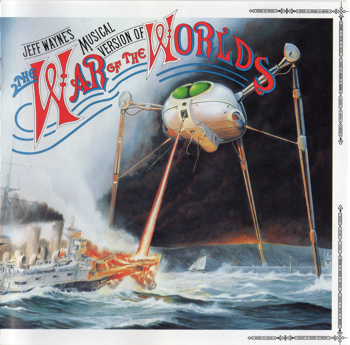

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9999998807907104)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.9999998807907104)

In [14]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_c_dig', 'JeffWayne', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978", 'front.png'))

#### 'Seen' Data

Tyically, a model wants to be generalised to unseen data, so that it can be be robust against any data it comes across.

However, in reality, the application of this roject is that it can be reasonably assumed that only album covers will be seen by the model. This is significant, as it means that the user input data will be _very_ similar to the actual test data. For example, look at the above image (official scan used in training) and the below image (a photo similar to what a user might have). Since they are both of the same album, they are almost identical, except for very small differences (particularly colour).

And, furthermore, as a physcial hardware device, it is likely to only ever service a fairly small number of albums in the user's collection.

Therefore, the model should be able to predict the correct label with high accuracy, as 'overfitting' to the training data serves the purpose of the project.

In [15]:
validateDataset(model, testDataset, printResults=True)

tensor([117,  60,  37,  37, 121, 122, 105, 113])
tensor([118, 119, 120, 120, 121, 122, 123, 123])
tensor([ 23, 100, 117, 126,   7, 115,  42,  41])
tensor([ 23, 124, 125, 126, 127, 128, 129, 130])
Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 

0.25

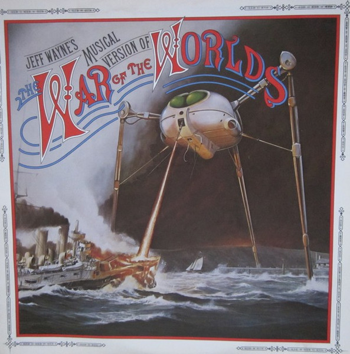

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.4304145872592926)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.4304145872592926)

In [16]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

### Unseen Data

Unseen data (the model is not expected to perform well).

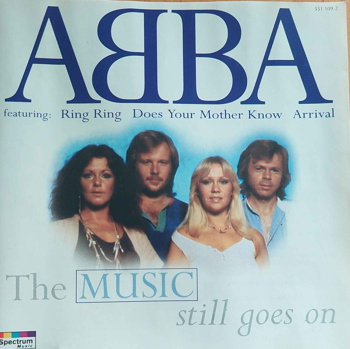

Predicted: RoadToNowhere_TalkingHeads_1985 (0.46766218543052673)
{'name': 'Road To Nowhere', 'artist': 'Talking Heads', 'year': '1985'}


('RoadToNowhere_TalkingHeads_1985', 0.46766218543052673)

In [17]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'TheMusicStillGoesOn_ABBA.jpg'))

Note: the sum of the probabilities will be 1. Therefore, with a small datatset, the model may be confidently wrong (i.e. a high probability for the wrong class), as this is moreso a measure of 'how confident I am it is this, compared to the other options', as opposed to 'how confident I am that it is this, and not anything else'. This is important to note when interpreting the results (we should have a high standard for confidence). However, as the dataset grows, the liklihood of any one class being highly-favoured, when the true result lies outside of the trained classes, should decrease.

#### Bad Data

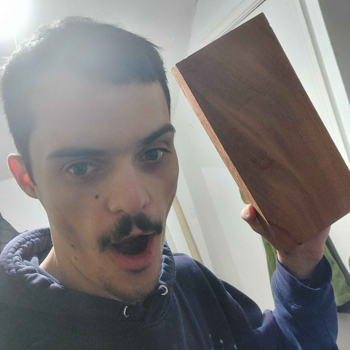

Predicted: 20OriginalDiscoHits_SoulCity_1978 (0.14658887684345245)
{'name': '20 Original Disco Hits', 'artist': 'Soul City', 'year': '1978'}


('20OriginalDiscoHits_SoulCity_1978', 0.14658887684345245)

In [18]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'MahoganyJack.jpg'))

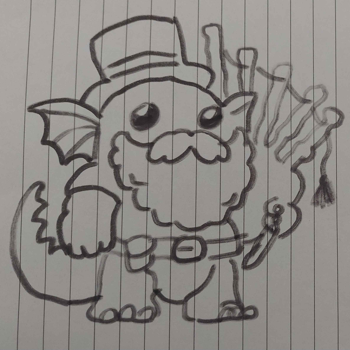

Predicted: RoadToNowhere_TalkingHeads_1985 (0.33336517214775085)
{'name': 'Road To Nowhere', 'artist': 'Talking Heads', 'year': '1985'}


('RoadToNowhere_TalkingHeads_1985', 0.33336517214775085)

In [19]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Haranthur.jpg'))

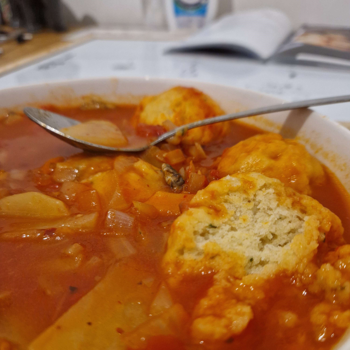

Predicted: AreYouExperienced_TheJimiHendrixExperience_1967 (0.37979477643966675)
{'name': 'Are You Experienced', 'artist': 'The Jimi Hendrix Experience', 'year': 1967}


('AreYouExperienced_TheJimiHendrixExperience_1967', 0.37979477643966675)

In [20]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Dumplings.jpg'))

In these examples, we see that the image is (fairly) confidently wrong, about this data, as it has not concept of what is a coverart, and what is not.

The best way to counter this, is to have a confidence threshold. If the model is not confident, it should not make a prediction, without using other fallback methods (e.g. OCR, etc.). As  the dataset increases, the confidence level should naturally decrease for unseen data, as the model will have more data to compare against.

### 'Empty' Data

However, there is one example of bad data that we can theoretically handle quite well: as the camera will be fixed, we have a strong idea of what background to expect. Therefore, we can have one class be trained on the background, whichmeans that when there is 'no data', it will be classified as the background. This will be useful for the 'unseen data' section, as we can see how well the model can differentiate between the background and the other classes.

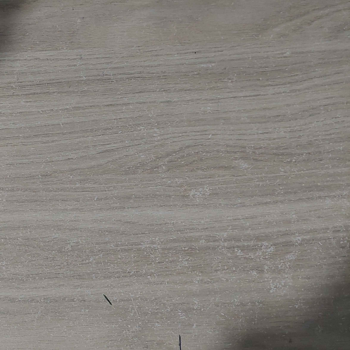

Predicted: _null (0.9978755712509155)
Unknown


('_null', 0.9978755712509155)

In [21]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_', '_null', '_null', 'null.jpg'))

**As the results of this data are essentially just a matter of 'is this already seen'?, formal evaluation of the model has been skipped, for now.**

## V. Observations

### 1. Model performs terribly on data belonging to unseen classes.
This is expected, and can be improved by:
- using a multi-headed model, for deeper analysis;
- using alternative fallback methods, such as barcode scanning, or OCR;
- and can be minimised by using a larger dataset, with more classes.

### 2. This model is not robust.
Rotating, flipping, warping, discolouring, and other augmentations to the base image can result in a completely different prediction. This is expected, and can be improved by:
- using an augmentated dataset, to make these cases not so 'unseen';
- using a larger dataset, with more classes (the arbitrary similarities between classes will be less likely to be learned);

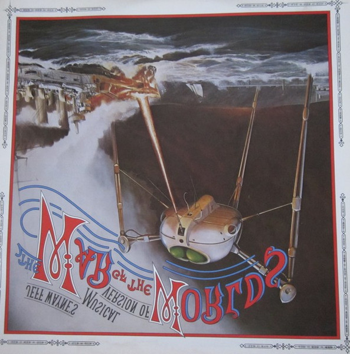

Predicted: Dummy_Portishead_1994 (0.6054472327232361)
{'name': 'Dummy', 'artist': 'Portishead', 'year': 1994}


('Dummy_Portishead_1994', 0.6054472327232361)

In [22]:
testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

# AUGMENT IMAGE
testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)

displayImage(testImage, 350)

# VALIDATE
testImage = globalTransformer(testImage)
testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

validate(model, testImage)

We can see that the model is still able to correctly identify this example, even when flipped. However, this specififc examle is quite symmetrical (the corner symbols, red border, etc.).

If we are to further distort the image, the results can become incorrect:

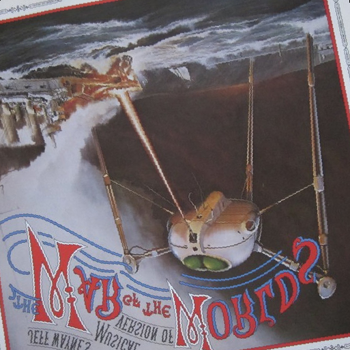

Predicted: RoadToNowhere_TalkingHeads_1985 (0.40688028931617737)
{'name': 'Road To Nowhere', 'artist': 'Talking Heads', 'year': '1985'}


('RoadToNowhere_TalkingHeads_1985', 0.40688028931617737)

In [23]:
testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

# AUGMENT IMAGE
testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)
testImage = testImage.rotate(10)
testImage = testImage.crop((40, 40, 553, 553))

displayImage(testImage, 350)

# VALIDATE
testImage = globalTransformer(testImage)
testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

validate(model, testImage)

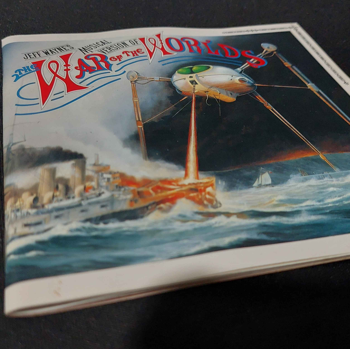

Predicted: MasterOfPuppets_Metallica_1986 (0.956964373588562)
{'name': 'Master Of Puppets', 'artist': 'Metallica', 'year': 1986}


('MasterOfPuppets_Metallica_1986', 0.956964373588562)

In [24]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(3).jpg"))